## Data Transformation and Feature Engineering Notebook

In [18]:
from glob import glob
import joblib
import pandas as pd
import seaborn as sns
from glob import glob
from dateutil.relativedelta import relativedelta
import datetime
import os
from io import StringIO
import numpy as np
from geopy.geocoders import Nominatim

% matplotlib inline

### Read in Electricity Load data
Specifying the grid parameter to the below function reads in data for only a specific grid.

In [6]:
def return_load_df(load_data_dir, grid='N.Y.C.', save=None):
    """
    Read in the load data files that have already been downloaded and return a pandas dataframe.
    of all the files concatenated.

    Args:
        load_data_dir: String: Directory where the load data is saved.
        grid: String: The name of the grid for which the data needs to be filtered.
        save: String: Directory where the dataframe to be returned should be dumped.

    Returns:
        load_df: Dataframe: Pandas dataframe of all the data in the load data files concatenated.
    """

    load_data_files = glob(load_data_dir + "/*.csv")
    # load_data_files = [f for f in load_data_files 
    #                if (not os.path.basename(f).startswith('2018') and 
    #                    not os.path.basename(f).startswith('2017'))]

    load_df = pd.read_csv(load_data_files[0])

    load_df = load_df.loc[load_df['Name'] == grid]

    for f in load_data_files[1:]:
        df = pd.read_csv(f)
        df = df.loc[df['Name'] == grid]
        load_df = pd.concat([load_df, df])

    if save:
        joblib.dump(load_df, os.path.join(save, 'load_df'))

    return load_df

load_df = return_load_df('/volumes/data/load_data', grid='N.Y.C.', save='/volumes/data/notebook2')

### Apply required transformations to the load dataframe.

In [8]:
def load_df_pipeline(load_df, save=None):
    """
    Apply the necessary transformations and operations to the load data dataframe to get it 
    in the proper form.

    Args:
        load_df: Dataframe: Pandas dataframe having the timeseries load data.
        save: String: Directory where the dataframe to be returned is to be stored.

    Returns:
        county_load_df_rolling: Dataframe: Pandas dataframe that has been properly 
            transformed and sampled hourly.
    """

    load_df['Time Stamp'] = pd.to_datetime(load_df['Time Stamp'])
    
    # remove duplicated indexes.
    load_df = load_df[~load_df['Time Stamp'].duplicated()].reset_index(drop=True)

    # Pivot dataframe to get County names as columns
    county_load_df = load_df.pivot(index='Time Stamp', columns='Name')

    # Resample data to hourly frequency
    county_load_df = county_load_df.resample('H').mean()

    county_load_df = county_load_df.dropna()

    # Remove spikes in the data using a moving average over a 1 hour window.
    county_load_df_rolling = county_load_df.rolling('H').mean()

    if save:
        joblib.dump(county_load_df_rolling, os.path.join(save, 'county_load_df_rolling'))

    return county_load_df_rolling

county_load_df_rolling = load_df_pipeline(load_df, save='/volumes/data/notebook2')
#county_load_df_rolling = joblib.load('/volumes/data/notebook2/county_load_df_rolling')

In [9]:
county_load_df_rolling.head()

,PTID,Load
Name,N.Y.C.,N.Y.C.
Time Stamp,,
2010-01-01 00:00:00,61761.0,5395.791667
2010-01-01 01:00:00,61761.0,5192.575000
2010-01-01 02:00:00,61761.0,4978.225000
2010-01-01 03:00:00,61761.0,4784.608333
2010-01-01 04:00:00,61761.0,4696.741667


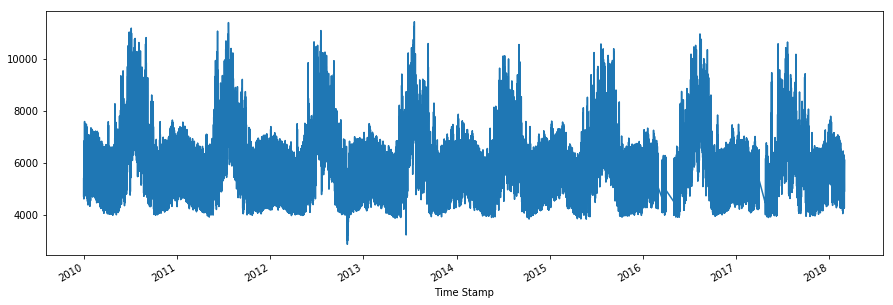

In [14]:
county_load_df_rolling['Load']['N.Y.C.'].plot(figsize=(15,5))

### Station Data

To get the relevant grid zones for all the stations based on their `WBAN` ids and their geolocation.

In [11]:
def return_station_df(station_data_dir, save=None):
    """
    Read in the station data files that have already been downloaded and return a pandas dataframe.
    of all the files concatenated.

    Args:
        station_data_dir: String: Directory where the station/weather data is saved.
        save: String: Directory where the dataframe to be returned is to be stored.

    Returns:
        station_df: Dataframe: Pandas dataframe of all the data in the load data files concatenated.
    """

    station_data_files = glob(station_data_dir + "/*station.txt")
    # station_data_files = [f for f in station_data_files 
    #                    if (not os.path.basename(f).startswith('2018') and 
    #                    not os.path.basename(f).startswith('2017'))]

    station_df = pd.concat(pd.read_csv(f, header=0, sep="|") for f in station_data_files)

    # Add this column to pass to the reverse geocoder later on.
    station_df['temp'] = station_df['Latitude'].astype(str) + ', ' + station_df['Longitude'].astype(str)

    if save:
        joblib.dump(station_df, os.path.join(save, 'station_df'))

    return station_df

station_df = return_station_df('/volumes/data/weather_data', save='/volumes/data/notebook2')

In [12]:
station_df.head()

,WBAN,WMO,CallSign,ClimateDivisionCode,ClimateDivisionStateCode,ClimateDivisionStationCode,Name,State,Location,Latitude,Longitude,GroundHeight,StationHeight,Barometer,TimeZone,temp
0,100.0,NaN,M89,NaN,3.0,NaN,ARKADELPHIA,AR,DEXTER B FLORENCE MEM FLD AP,34.09972,-93.06583,182.0,NaN,NaN,-6.0,"34.09972, -93.06583"
1,101.0,NaN,KQHT,NaN,NaN,NaN,BISHKEK,NaN,MANAS INTERNATIONAL AIRPORT,43.06700,74.48300,2090.0,NaN,NaN,6.0,"43.067, 74.483"
2,102.0,NaN,IAN,NaN,50.0,NaN,KIANA,AK,BOB BARKER MEMORIAL AIRPORT,66.98300,-160.43300,168.0,NaN,NaN,-9.0,"66.983, -160.433"
3,103.0,NaN,IWK,NaN,50.0,NaN,WALES,AK,WALES AIRPORT,65.61700,-168.10000,23.0,NaN,NaN,-9.0,"65.617, -168.1"
4,104.0,NaN,FSP,NaN,50.0,NaN,NIKOLAI,AK,NIKOLAI AIRPORT,63.01700,-154.36700,414.0,NaN,NaN,-9.0,"63.016999999999996, -154.36700000000002"


### Define the dictionary mapping of zones and counties.

#### Reference for zones and counties below: http://www.nyiso.com/public/webdocs/markets_operations/market_data/zone_maps_graphs/nyca_zonemaps.pdf

In [15]:
zones = {
        "A" : "WEST",
        "B" : "GENESE",
        "C" : "CENTRL",
        "D" : "NORTH",
        "E" : "MHK VL",
        "F" : "CAPITL",
        "G" : "HUD VL",
        "H" : "MILLWD",
        "I" : "DUNWOD",
        "J" : "N.Y.C.",
        "K" : "LONGIL"}

# Counties
counties2zones = {
        "Clinton" : "D",
        "Saint Lawrence" : "E",
        "Jefferson" : "E",
        "Lewis" : "E",
        "Franklin" : "E",
        "Oneida" : "E",
        "Herkimer" : "E",
        "Madison" : "E",
        "Otsego" : "E",
        "Chenango" : "E",
        "Delaware" : "E",
        "Sullivan" : "E",
        "Essex" : "F",
        "Warren" : "F",
        "Hamilton" : "F",
        "Fulton" : "F",
        "Saratoga" : "F",
        "Washington" : "F",
        "Montgomery" : "F",
        "Schenectady" : "F",
        "Albany" : "F",
        "Schoharie" : "F",
        "Rensselaer" : "F",
        "Columbia" : "F",
        "Dutchess" : "G",
        "Ulster" : "G",
        "Orange" : "G",
        "Putnam" : "G",
        "Rockland" : "G",
        "Oswego" : "C",
        "Onondaga" : "C",
        "Cayuga" : "C",
        "Cortland" : "C",
        "Broome" : "C",
        "Tioga" : "C",
        "Tompkins" : "C",
        "Seneca" : "C",
        "Chemung" : "C",
        "Schuyler" : "C",
        "Yates" : "C",
        "Steuben" : "C",
        "Chautauqua" : "A",
        "Cattaraugus" : "A",
        "Erie" : "A",
        "Niagara" : "A",
        "Orleans" : "A",
        "Genesee" : "A",
        "Wyoming" : "A",
        "Livingston" : "A",
        "Monroe" : "B",
        "Wayne" : "B",
        "Ontario" : "B",
        "Allegany" : "B",
        "Westchester" : "I",
        "New York" : "J",
        "Bronx" : "J",
        "Richmond" : "J",
        "Kings" : "J",
        "Queens" : "J",
        "Nassau" : "K",
        "Suffolk" : "K"}

### Get unique weather station WBANs in the N.Y.C. zone.

In [19]:
geolocator = Nominatim()

def get_state_and_zones_wbans(df, state = 'NY', zone = 'N.Y.C.', save=None):
    """
    Get the unique WBANS in the state and zone from station data.
    Args:
        df: Dataframe: Station dataframe 
        state: String: Name of the state that the data needs to filtered on.
        zone: String: Name of the zone/grid that the 
            station belongs to (As per load data)
        save: String: Directory where the unique WBANs should be stored.
    
    Returns: List: Unique WBANS in the particular load grid.
    """
    
    # Get county from coordinates
    def get_county(s):
        loc = geolocator.reverse(s)
        address = loc.raw.get('address', None)
        if address:
            county = address.get('county', 'NA')
        else:
            county = 'NA'
        return county

    def county_to_zone_name(s):
        county_name = " ".join(s.split()[:-1])
        zone = counties2zones.get(county_name, 'NA')
        zone_name = zones.get(zone, 'NA')
        return zone_name
    

    state_station_df = df[df['State'] == state]

    wban_coordinates = state_station_df.set_index('WBAN')['temp'].to_dict()
    
    wban_counties = {k : get_county(v) 
            for k, v in wban_coordinates.items()}
    
    # Get counties from WBANS.
    state_station_df['county'] = state_station_df['WBAN'].replace(wban_counties)

    # Convert counties to zone names (as per load data)
    state_station_df['zone'] = state_station_df['county'].apply(county_to_zone_name)

    # Filter for specific zone.
    state_station_df = state_station_df[state_station_df['zone'] == zone] # == 'N.Y.C.']

    unique_zone_wbans = np.unique(state_station_df['WBAN'].astype(int).tolist())

    if save:
        joblib.dump(unique_zone_wbans, os.path.join(save, 'unique_zone_wbans'))

    return unique_zone_wbans
                    
                    
nyc_weather_stations = get_state_and_zones_wbans(
    station_df, state='NY', zone='N.Y.C.', save='/volumes/data/notebook2')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
nyc_weather_stations

array([14732, 94728, 94789])

### Read in Weather data.

In [21]:
def return_weather_df(weather_data_dir, unique_zone_wbans, save=None):
    """
    Return the processed and filtered weather data files as concatenated dataframes.

    Args:
        weather_data_dir: String: Directory name where the weather data is saved
        unique_zone_wbans: List: List of WBAN ids that are specific to the grid we are reading
            the weather data for.
        save: String: Directory where the weather dataframe should be saved.

    Returns:
        weather_df: Dataframe: Dataframe of the filtered weathter data.
    """

    # Create timestamp column in weather_df
    ## We have to parse the string to get the proper HH:MM format data.
    def get_time(s):
        s = str(s)
        if len(s) == 1:
            return f'00:0{s}'
        elif len(s) == 2:
            return f'00:{s[0]}{s[1]}'
        elif len(s) == 3:
            return f'0{s[0]}:{s[1]}{s[2]}'
        elif len(s) == 4:
            return f'{s[0]}{s[1]}:{s[2]}{s[3]}'
        else:
            return '00:00'

    weather_data_files = glob(weather_data_dir + "/*hourly.txt")

    # weather_data_files = [f for f in weather_data_files 
    #                        if (not os.path.basename(f).startswith('2018') and 
    #                            not os.path.basename(f).startswith('2017'))]

    unnecessary_features = [
       'StationType', 'SkyCondition',
       'SkyConditionFlag', 'Visibility', 'VisibilityFlag', 'WeatherType',
       'WeatherTypeFlag', 'DryBulbFarenheit', 'DryBulbFarenheitFlag',
       'DryBulbCelsiusFlag', 'WetBulbFarenheit',
       'WetBulbFarenheitFlag', 'WetBulbCelsius', 'WetBulbCelsiusFlag',
       'DewPointFarenheit', 'DewPointFarenheitFlag', 
       'DewPointCelsiusFlag', 'RelativeHumidity', 'RelativeHumidityFlag',
       'WindSpeed', 'WindSpeedFlag', 'WindDirection', 'WindDirectionFlag',
       'ValueForWindCharacter', 'ValueForWindCharacterFlag', 'StationPressure',
       'StationPressureFlag', 'PressureTendency', 'PressureTendencyFlag',
       'PressureChange', 'PressureChangeFlag', 'SeaLevelPressure',
       'SeaLevelPressureFlag', 'RecordType', 'RecordTypeFlag', 'HourlyPrecip',
       'HourlyPrecipFlag', 'Altimeter', 'AltimeterFlag']

    def process_weather_df(frame):
        for u_feature in unnecessary_features:
            del frame[u_feature]
        frame = frame[frame['WBAN'].isin(unique_zone_wbans)]
        return frame

    weather_df_zone = pd.concat(
            process_weather_df(pd.read_csv(f)) for f in weather_data_files)

    #weather_df_zone = weather_df_nyc[~weather_df_nyc['Date'].astype(str).str.contains('2017|2018')]

    # Apply the `get_time` function to the entire `Time` column to parse the HH:MM data.
    weather_df_zone['Time'] = weather_df_zone['Time'].apply(get_time)

    # Join the date and time data to get a datestring which can be converted to a datetime object.
    weather_df_zone['Timestamp'] = weather_df_zone['Date'].astype(str) + ' ' + weather_df_zone['Time'].astype(str)

    # Convert to datetime.
    weather_df_zone['Timestamp'] = pd.to_datetime(weather_df_zone['Timestamp'], format='%Y%m%d %H:%M')
    
    weather_df_zone.index = weather_df_zone['Timestamp']
    del weather_df_zone.index.name

    # Process to get rid of the duplicated index error that comes up when trying to pivot the dataframe.
    weather_df_zone = weather_df_zone.set_index(['Timestamp', 'WBAN'])
    weather_df_zone = weather_df_zone[~weather_df_zone.index.duplicated(keep='first')]

    weather_df_zone = weather_df_zone.reset_index()
    weather_df_zone.index = weather_df_zone['Timestamp']

    temp = weather_df_zone.pivot(index='Timestamp', columns='WBAN')

    temp2 = temp[['DryBulbCelsius', 'DewPointCelsius']].replace({'M': None})

    temperature_data = temp2['DryBulbCelsius'].astype(float)
    dewpoint_data = temp2['DewPointCelsius'].astype(float)

    # axis=1 returns the mean across the row instead of column (axis=0)
    temperature_data['station_agg_temp'] = temperature_data.mean(axis=1)
    dewpoint_data['station_agg_dp'] = dewpoint_data.mean(axis=1)

    # Interpolate values for missing time stamps.
    temperature_data['station_agg_temp'] = temperature_data['station_agg_temp'].interpolate(method='linear', axis=0).ffill().bfill()
    dewpoint_data['station_agg_dp'] = dewpoint_data['station_agg_dp'].interpolate(method='linear', axis=0).ffill().bfill()

    weather_features = temperature_data.merge(
        dewpoint_data,
        how='inner',
        left_index=True,
        right_index=True)

    # Do an hourly resample of the data.
    weather_features_hourly = weather_features.resample('H').mean()

    weather_features_hourly = weather_features_hourly[
            ['station_agg_temp', 'station_agg_dp']]

    if save:
        joblib.dump(weather_features_hourly, os.path.join(save, 'weather_features_hourly'))

    return weather_features_hourly

weather_features_hourly = return_weather_df(
    '/volumes/data/weather_data', 
    nyc_weather_stations, 
    save='/volumes/data/notebook2')

In [22]:
weather_features_hourly = joblib.load('/volumes/data/notebook2/weather_features_hourly')

In [23]:
weather_features_hourly.head()

WBAN,station_agg_temp,station_agg_dp
Timestamp,,
2010-01-01 00:00:00,0.883333,-0.20
2010-01-01 01:00:00,0.986667,0.04
2010-01-01 02:00:00,0.986667,0.44
2010-01-01 03:00:00,0.883333,0.60
2010-01-01 04:00:00,0.883333,0.50


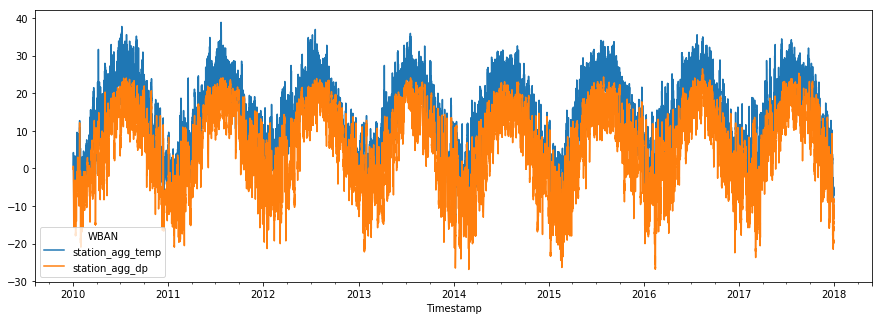

In [24]:
weather_features_hourly.plot(figsize=(15,5))

### Load data dataframe: `county_load_df_rolling` 
### Weather data dataframe: `weather_features_hourly`

We now combine the electricity load data and weather data together in a single dataframe.

In [25]:
def combine_load_weather_df(county_load_df_rolling, weather_features_hourly, save=None):
    """
    Combine the load dataframe and the weather dataframes into a single dataframe.

    Args:
        county_load_df_rolling: Dataframe: Load data for the specific county, 
            filtered and cleaned.
        weather_features_hourly: Dataframe: Weather data.

    Returns:
        load_and_weather_data_final: Dataframe: Combined dataframe containing
            both weather and load features for the same timestamps.
    """

    del weather_features_hourly.columns.name
    del weather_features_hourly.index.name

    load_and_weather_data = pd.merge(
        weather_features_hourly,
        county_load_df_rolling['Load'],
        how='outer',
        left_index=True,
        right_index=True)

    load_and_weather_data.columns = ['temperature', 'dewpoint', 'load']

    # interpolate any missing values linearly.
    load_and_weather_data = load_and_weather_data.interpolate(
            method='linear', axis=0).ffill().bfill()

    # Build date and time features.
    load_and_weather_data['year'] = load_and_weather_data.index.map(lambda x: x.year)
    load_and_weather_data['month'] = load_and_weather_data.index.map(lambda x: x.month)
    load_and_weather_data['day'] = load_and_weather_data.index.map(lambda x: x.day)
    load_and_weather_data['weekday'] = load_and_weather_data.index.map(lambda x: x.weekday)
    load_and_weather_data['hour'] = load_and_weather_data.index.map(lambda x: x.hour)

    # Build lagged weather predictors.
    for ix in range(8):
        load_and_weather_data['temperature_d' + str(ix)] = load_and_weather_data['temperature'].shift(24*ix)
        load_and_weather_data['dewpoint_d' + str(ix)] = load_and_weather_data['dewpoint'].shift(24*ix)

    # Next day's load values.
    load_and_weather_data['load_tomorrow'] = load_and_weather_data['load'].shift(-24)

    load_and_weather_data = load_and_weather_data.fillna(0)

    if save:
        joblib.dump(load_and_weather_data, os.path.join(save, 'load_and_weather_data'))

    return load_and_weather_data

load_and_weather_data = combine_load_weather_df(
    county_load_df_rolling, weather_features_hourly, save='/volumes/data/notebook2')

In [26]:
load_and_weather_data.head()

,temperature,dewpoint,load,year,month,day,weekday,hour,temperature_d0,dewpoint_d0,...,dewpoint_d3,temperature_d4,dewpoint_d4,temperature_d5,dewpoint_d5,temperature_d6,dewpoint_d6,temperature_d7,dewpoint_d7,load_tomorrow
2010-01-01 00:00:00,0.883333,-0.20,5395.791667,2010,1,1,4,0,0.883333,-0.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5151.941667
2010-01-01 01:00:00,0.986667,0.04,5192.575000,2010,1,1,4,1,0.986667,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4907.616667
2010-01-01 02:00:00,0.986667,0.44,4978.225000,2010,1,1,4,2,0.986667,0.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4758.416667
2010-01-01 03:00:00,0.883333,0.60,4784.608333,2010,1,1,4,3,0.883333,0.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4646.358333
2010-01-01 04:00:00,0.883333,0.50,4696.741667,2010,1,1,4,4,0.883333,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4612.775000


### Perform feature normalization
We do this only using a StandardScaler that is fit on the period from 2010-2016, as we will be using the data from 2017 as the testing data.

In [28]:
def process_df_for_training(load_and_weather_data, save=None, save_list=None):
    """
    Args: 
        load_and_weather_data: Dataframe: Dataframe of load and weather features (unprocessed)
        save: String: Directory where objects should be stored.
        save_list: List: List of objects to save. Can be one or more of - 
            - features_to_normalize
            - scaler_dict
            - load_and_weather_data_final
    Returns:
        load_and_weather_data_final: Dataframe: The standardized dataframe of features.
        features: List: The list of features to be used in the training.

    """
    features_to_normalize = [
        'load',
        'temperature_d0', 'dewpoint_d0',
        'temperature_d1', 'dewpoint_d1',
        'temperature_d2', 'dewpoint_d2',
        'temperature_d3', 'dewpoint_d3',
        'temperature_d4', 'dewpoint_d4',
        'temperature_d5', 'dewpoint_d5',
        'temperature_d6', 'dewpoint_d6',
        'temperature_d7', 'dewpoint_d7']
    

    as_is_features = [feature 
                  for feature in load_and_weather_data.columns 
                  if feature not in features_to_normalize]


    from sklearn.preprocessing import StandardScaler

    norm_features_df = load_and_weather_data[features_to_normalize]
    scaler_dict = {}

    for norm_feature in features_to_normalize:
        scaler = StandardScaler()
        norm_features_df[norm_feature] = scaler.fit_transform(
                norm_features_df[norm_feature].values.reshape(-1,1))
        scaler_dict[norm_feature] = scaler

    load_and_weather_data_std = pd.concat(
        [load_and_weather_data[as_is_features], norm_features_df], axis=1)

    load_and_weather_data_final = pd.get_dummies(
        load_and_weather_data_std,
        columns=['month', 'weekday', 'day'])

    # features to use in training
    features = [
        feature for feature in load_and_weather_data_final.columns
        if ('dewpoint_' in feature or 
            'temperature_' in feature or
            'month_' in feature or 
            'weekday_' in feature or
            'day_' in feature or
            'year' == feature or
            'load' == feature or 
            'hour' == feature)]

    if save:
        if 'features_to_normalize' in save_list:
            joblib.dump(features_to_normalize, os.path.join(save, 'features_to_normalize'))
        if 'scaler_dict' in save_list:
            joblib.dump(scaler_dict, os.path.join(save, 'scaler_dict'))
        if 'load_and_weather_data_final' in save_list:
            joblib.dump(load_and_weather_data_final, os.path.join(save, 'load_and_weather_data_final'))


    return load_and_weather_data_final, features, scaler_dict

load_and_weather_data_final, features, scaler_dict = process_df_for_training(
    load_and_weather_data['2010-01-01':'2016-12-31'], save='/volumes/data/notebook2', save_list=[
        'features_to_normalize', 'scaler_dict', 'load_and_weather_data_final'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
load_and_weather_data_final.head()

,temperature,dewpoint,year,hour,load_tomorrow,load,temperature_d0,dewpoint_d0,temperature_d1,dewpoint_d1,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2010-01-01 00:00:00,0.883333,-0.20,2010,0,5151.941667,-0.543726,-1.270118,-0.528462,-1.359919,-0.510011,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:00:00,0.986667,0.04,2010,1,4907.616667,-0.698263,-1.259566,-0.505918,-1.359919,-0.510011,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,0.986667,0.44,2010,2,4758.416667,-0.861267,-1.259566,-0.468345,-1.359919,-0.510011,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 03:00:00,0.883333,0.60,2010,3,4646.358333,-1.008503,-1.270118,-0.453316,-1.359919,-0.510011,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 04:00:00,0.883333,0.50,2010,4,4612.775000,-1.075322,-1.270118,-0.462709,-1.359919,-0.510011,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# features that will be used for training.
features

['year',
 'hour',
 'load',
 'temperature_d0',
 'dewpoint_d0',
 'temperature_d1',
 'dewpoint_d1',
 'temperature_d2',
 'dewpoint_d2',
 'temperature_d3',
 'dewpoint_d3',
 'temperature_d4',
 'dewpoint_d4',
 'temperature_d5',
 'dewpoint_d5',
 'temperature_d6',
 'dewpoint_d6',
 'temperature_d7',
 'dewpoint_d7',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31']